# erreur sur charge hydraulique stratifié

In [1]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1. Chargement des données et définition d'un objet ``Column``

On doit d'abord récupérer les données issues des capteurs, qui se trouvent dans le dossier ``data``.

In [2]:
capteur_riviere = pd.read_csv("../data/Point034_processed/processed_pressures.csv", sep = ',', names = ['dates', 'tension', 'temperature_riviere'], skiprows=1)
capteur_ZH = pd.read_csv("../data/Point034_processed/processed_temperatures.csv", sep = ',', names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], skiprows=1)
etalonage_capteur_riv = pd.read_csv("../configuration/pressure_sensors/P508.csv")

On définit une fonction pour convertir les dates des dataframe, cela peut éviter certains problèmes.

In [3]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

convertDates(capteur_riviere)
convertDates(capteur_ZH)

On définit les objets ``dH_measures`` et ``T_measures``, nécessaires à la création d'un objet ``Column``, qui réalisera les calculs :
- ``dH_measures`` contient les dates des mesures, les mesures de différence de charge, et les températures de la rivière.
- ``T_measures`` contient les dates des mesures, et les températures mesurées par les 4 capteurs de la tige.

In [4]:
# set seed for reproducibility
np.random.seed(0)

# conversion des mesures de pression
intercept = float(etalonage_capteur_riv['P508'][2])
a = float(etalonage_capteur_riv['P508'][3])
b = float(etalonage_capteur_riv['P508'][4])
capteur_riviere['dH'] = (capteur_riviere['tension'].astype(float)-intercept-capteur_riviere['temperature_riviere'].astype(float)*b)/a
# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + 273.15
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + 273.15
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + 273.15
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + 273.15
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + 273.15

# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

On définit maintenant l'objet ``Column`` à partir d'un dictionnaire.

In [5]:
col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, .4],
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange'
}

col = Column.from_dict(col_dict)

L'objet créé a déjà un certain nombre d'attributs, certains étant initialisés. Se reporter au code ``core.py``.

In [6]:
temps_en_jours = np.array([i for i in range(len(col._times))]) / (4*24)

## 2. Modèle direct

Le modèle direct calcule les températures au cours du temps dans la colonne. Ensuite, on a accès aux flux, à la RMSE...

### 2.1. Colonne homogène

Pour une colonne homogène, on définit un seul jeu de paramètres, par un tuple ou via la classe ``Param`` :

In [7]:
params = Param(
    moinslog10K = 4,
    n = .1,
    lambda_s = 2,
    rhos_cs = 4e6
)

params_tuple = (4, .1, 2, 4e6)

assert params == params_tuple

Puis on appelle le modèle direct :

In [8]:
col.compute_solve_transi(params, nb_cells=100)

--- Compute Solve Transi ---
One layer : moinslog10K = 4, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0
Done.


### 2.2. Colonne stratifiée

Pour une colonne stratifiée, on doit d'abord définir une liste d'objets ``Layer`` :

In [9]:
layers_list = layersListCreator([("Couche 1", 0.20, 4, 0.1, 2, 4e6), ("Couche 2", 0.40, 6, 0.1, 2, 4e6)])

Puis on appelle le modèle direct :

charge hydraulique sur chaque interface [0.84556517 0.83719324 0.        ]


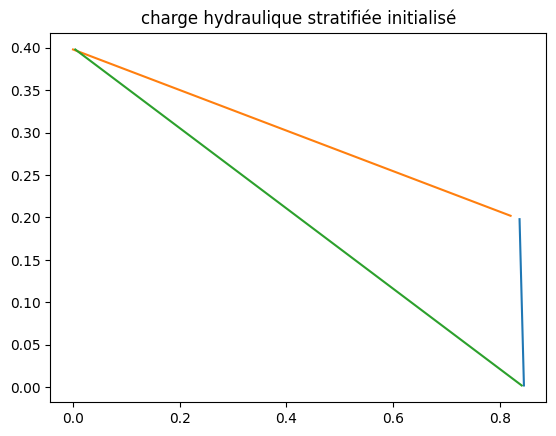

--- Compute Solve Transi ---
Couche 1 : ends at 0.2 m. Parametres(moinslog10K=4, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Couche 2 : ends at 0.4 m. Parametres(moinslog10K=6, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Done.


In [10]:
col.compute_solve_transi(layers_list, nb_cells=100)

### 2.3. Récupération des résultats

**Attention : les paramètres utilisés étant arbitraires, les résultats peuvent ne pas avoir de sens physique.**

On peut récupérer les températures calculées :

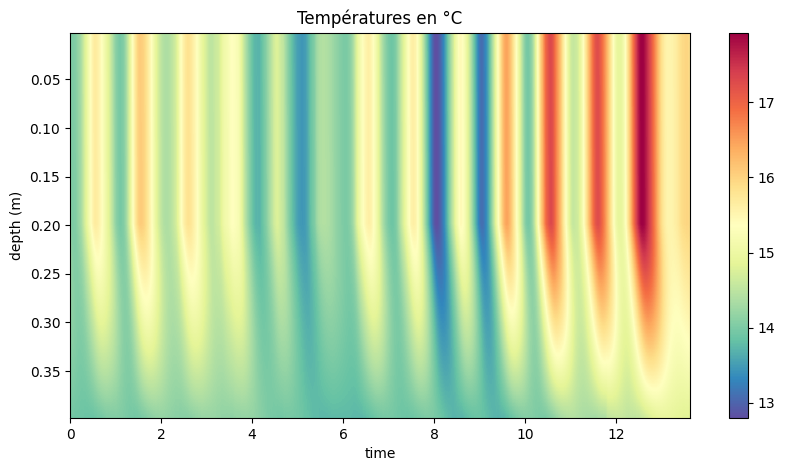

In [11]:
temperatures = col.get_temps_solve() - 273.15

fig, ax = plt.subplots(figsize=(10, 5), facecolor = 'w')

im = ax.imshow(
    temperatures,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = "Spectral_r"
)

ax.set_xlabel("time")
ax.set_ylabel("depth (m)")
ax.set_title("Températures en °C")
plt.colorbar(im)
plt.show()

Les débits :

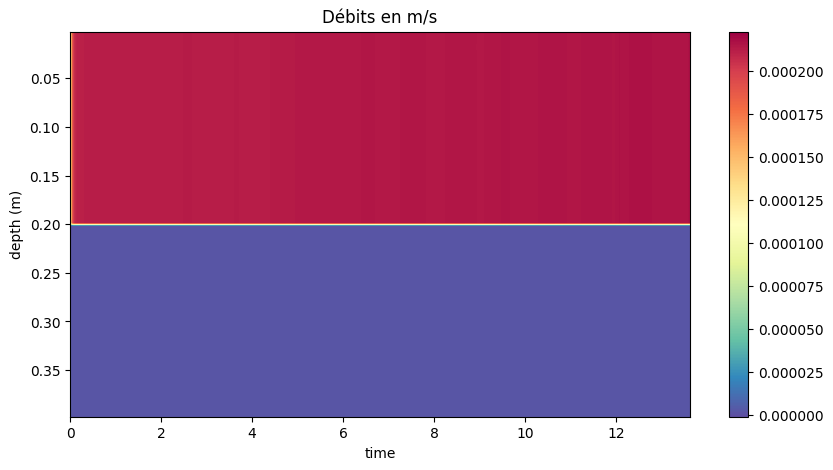

In [12]:
flows = col.get_flows_solve()

fig, ax = plt.subplots(figsize=(10, 5), facecolor = 'w')

im = ax.imshow(
    flows,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = "Spectral_r"
)

ax.set_xlabel("time")
ax.set_ylabel("depth (m)")
ax.set_title("Débits en m/s")
plt.colorbar(im)
plt.show()

Les flux advectifs et conductifs :

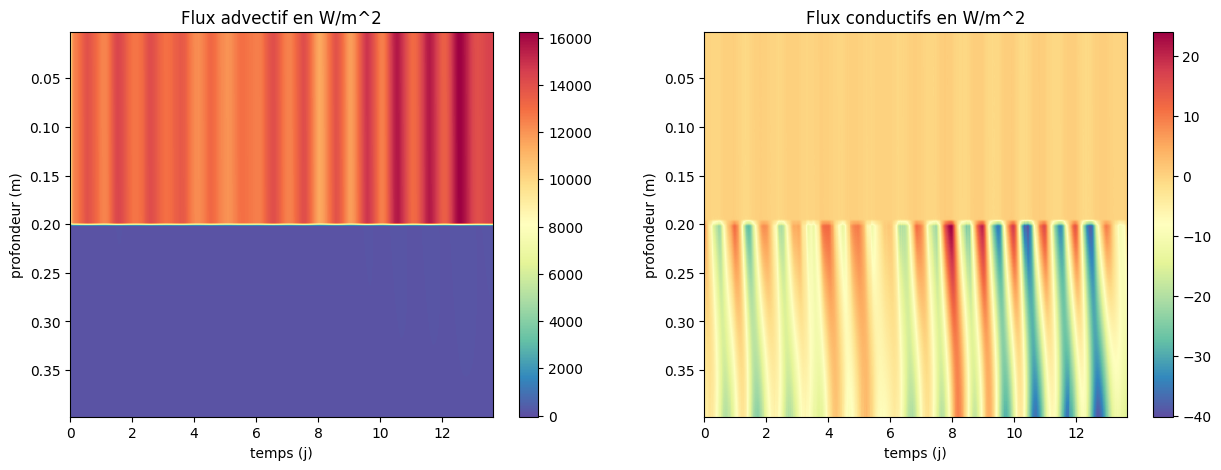

In [13]:
flux_advectifs = col.get_advec_flows_solve()
flux_conductifs = col.get_conduc_flows_solve()

fig, axes = plt.subplots(1, 2, figsize=(15, 5), facecolor = 'w')

im0 = axes[0].imshow(
    flux_advectifs,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = 'Spectral_r'
)

axes[0].set_xlabel("temps (j)")
axes[0].set_ylabel("profondeur (m)")
axes[0].set_title("Flux advectif en W/m^2")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(
    flux_conductifs,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = 'Spectral_r'
)

axes[1].set_xlabel("temps (j)")
axes[1].set_ylabel("profondeur (m)")
axes[1].set_title("Flux conductifs en W/m^2")
plt.colorbar(im1, ax=axes[1])

plt.show()

On peut aussi afficher tout d'un seul coup : (si on a la bonne version de matplotlib)

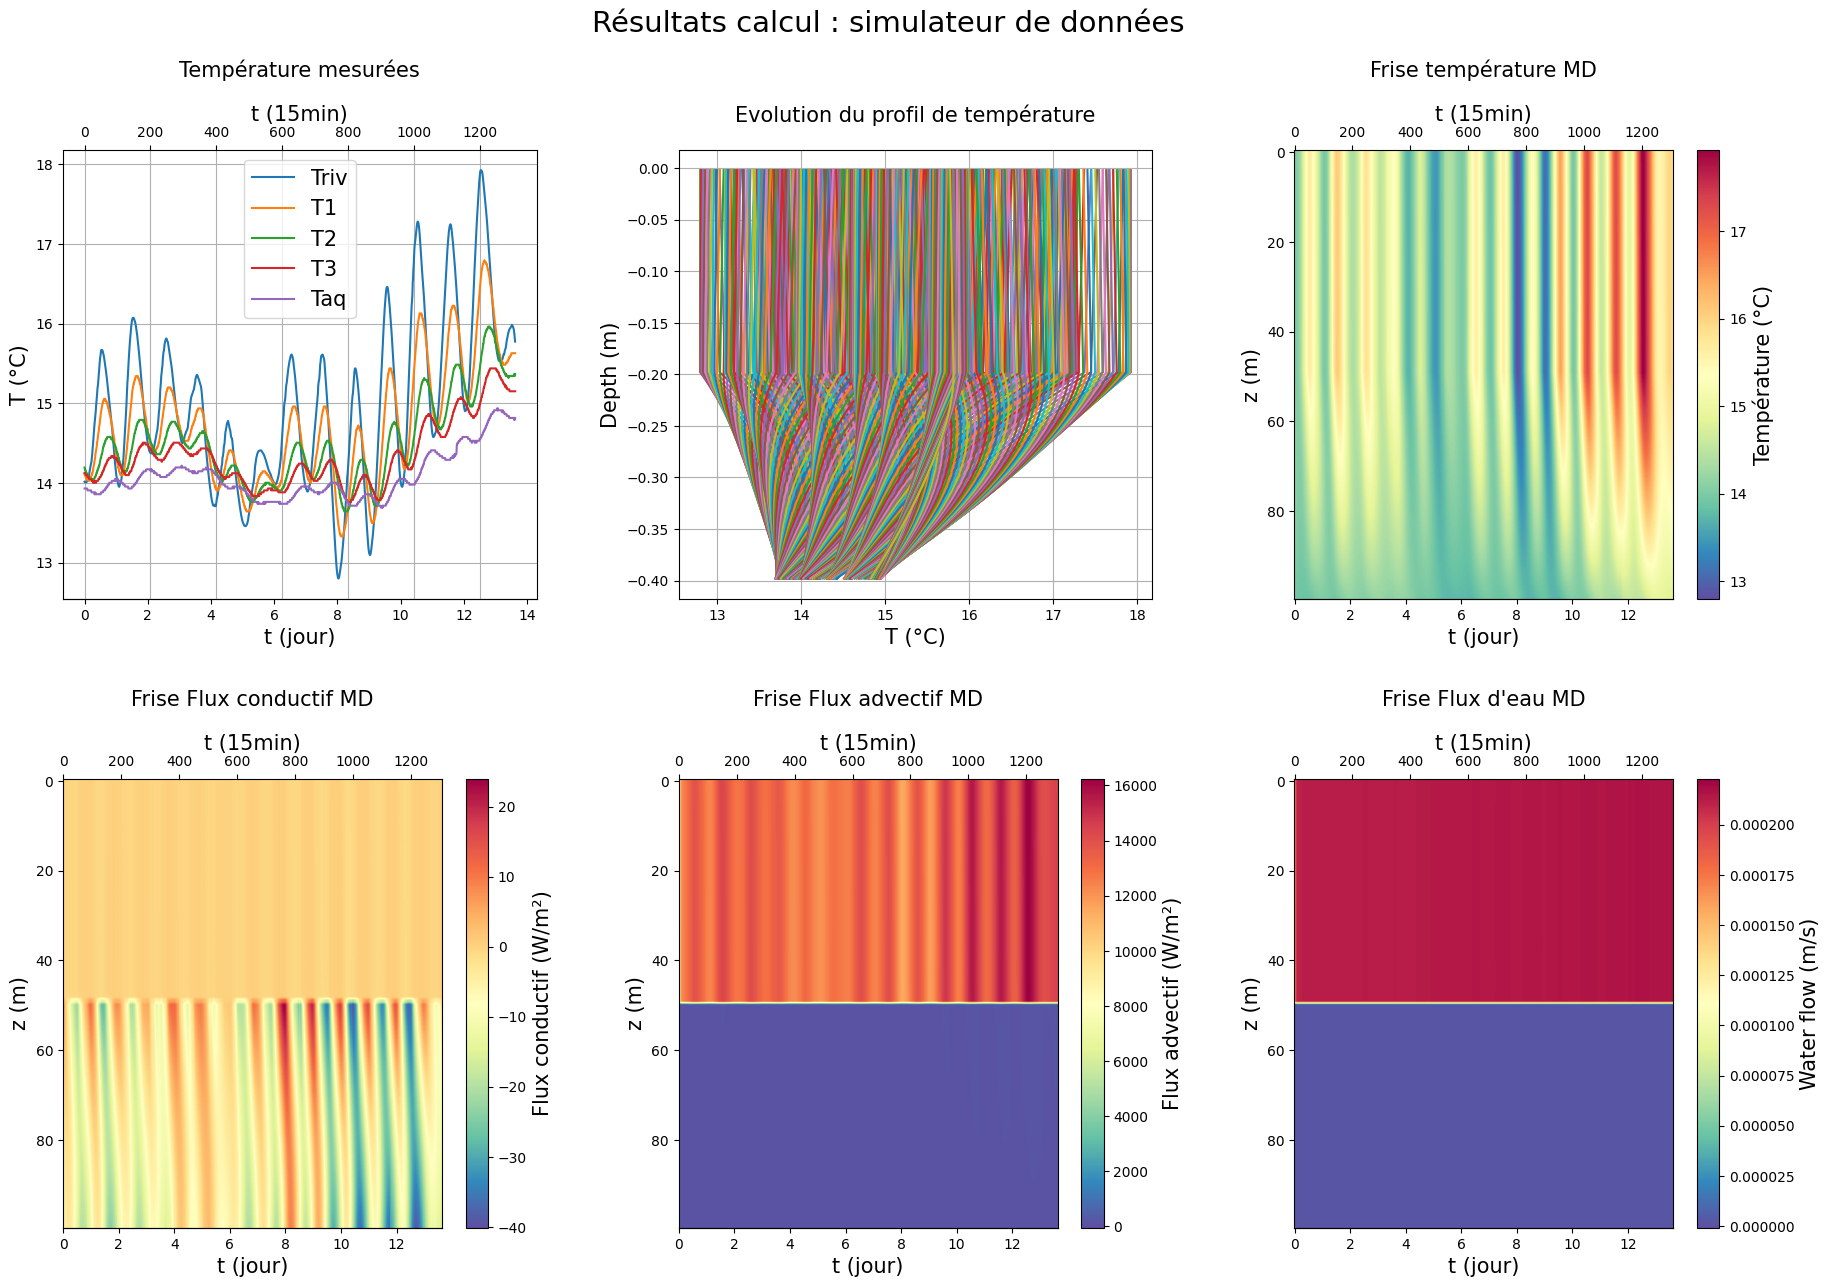

In [14]:
col.plot_CALC_results(nt=len(col._times))

### zhan: cas charge hydraulique stratifié temporellement permanante

charge hydraulique sur chaque interface [0.84556517 0.83719324 0.        ]


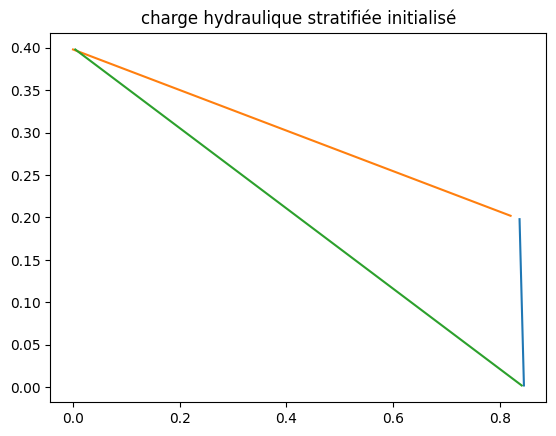

--- Compute Solve Transi ---
Couche 1 : ends at 0.2 m. Parametres(moinslog10K=4, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Couche 2 : ends at 0.4 m. Parametres(moinslog10K=6, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Done.


In [15]:
col.compute_solve_transi(layers_list, nb_cells=100, verbose = True, perm = True)

In [16]:
print(col._H_res)

[[0.84548146 0.84548146 0.84548146 ... 0.84548146 0.84548146 0.84548146]
 [0.845314   0.845314   0.845314   ... 0.845314   0.845314   0.845314  ]
 [0.8451466  0.8451466  0.8451466  ... 0.8451466  0.8451466  0.8451466 ]
 ...
 [0.03348773 0.03348773 0.03348773 ... 0.03348773 0.03348773 0.03348773]
 [0.01674386 0.01674386 0.01674386 ... 0.01674386 0.01674386 0.01674386]
 [0.         0.         0.         ... 0.         0.         0.        ]]


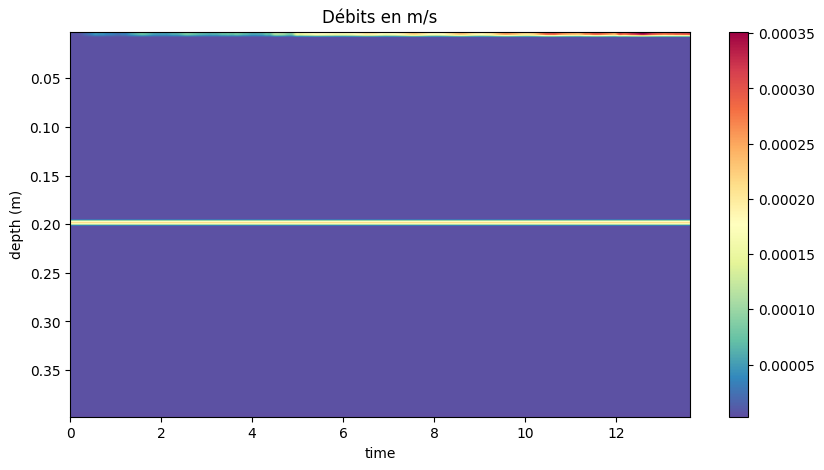

In [17]:
flows = col.get_flows_solve()

fig, ax = plt.subplots(figsize=(10, 5), facecolor = 'w')

im = ax.imshow(
    flows,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = "Spectral_r"
)

ax.set_xlabel("time")
ax.set_ylabel("depth (m)")
ax.set_title("Débits en m/s")
plt.colorbar(im)
plt.show()

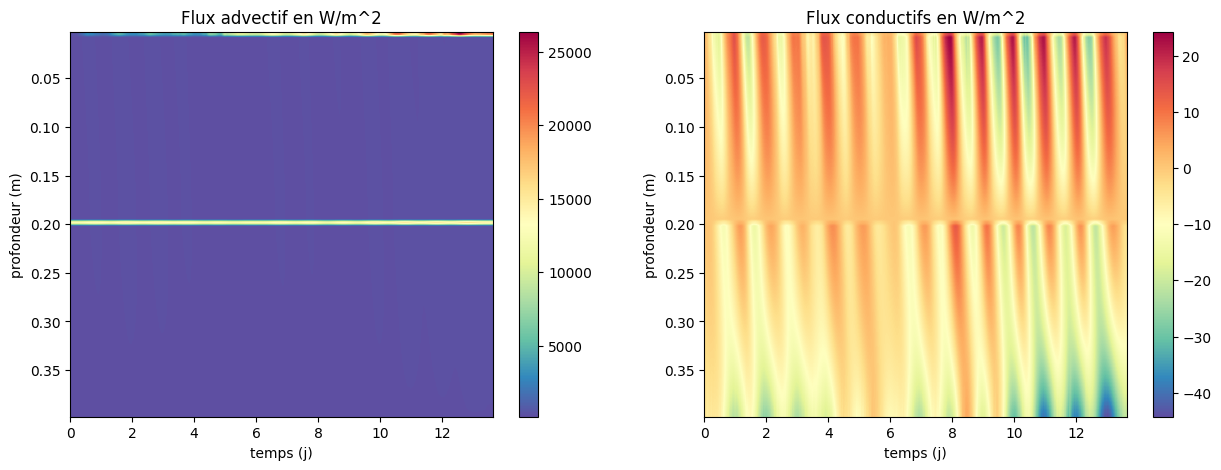

In [18]:
flux_advectifs = col.get_advec_flows_solve()
flux_conductifs = col.get_conduc_flows_solve()

fig, axes = plt.subplots(1, 2, figsize=(15, 5), facecolor = 'w')

im0 = axes[0].imshow(
    flux_advectifs,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = 'Spectral_r'
)

axes[0].set_xlabel("temps (j)")
axes[0].set_ylabel("profondeur (m)")
axes[0].set_title("Flux advectif en W/m^2")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(
    flux_conductifs,
    aspect = "auto",
    extent = [0, temps_en_jours[-1], col.depths_solve[-1], col.depths_solve[0]],
    cmap = 'Spectral_r'
)

axes[1].set_xlabel("temps (j)")
axes[1].set_ylabel("profondeur (m)")
axes[1].set_title("Flux conductifs en W/m^2")
plt.colorbar(im1, ax=axes[1])

plt.show()

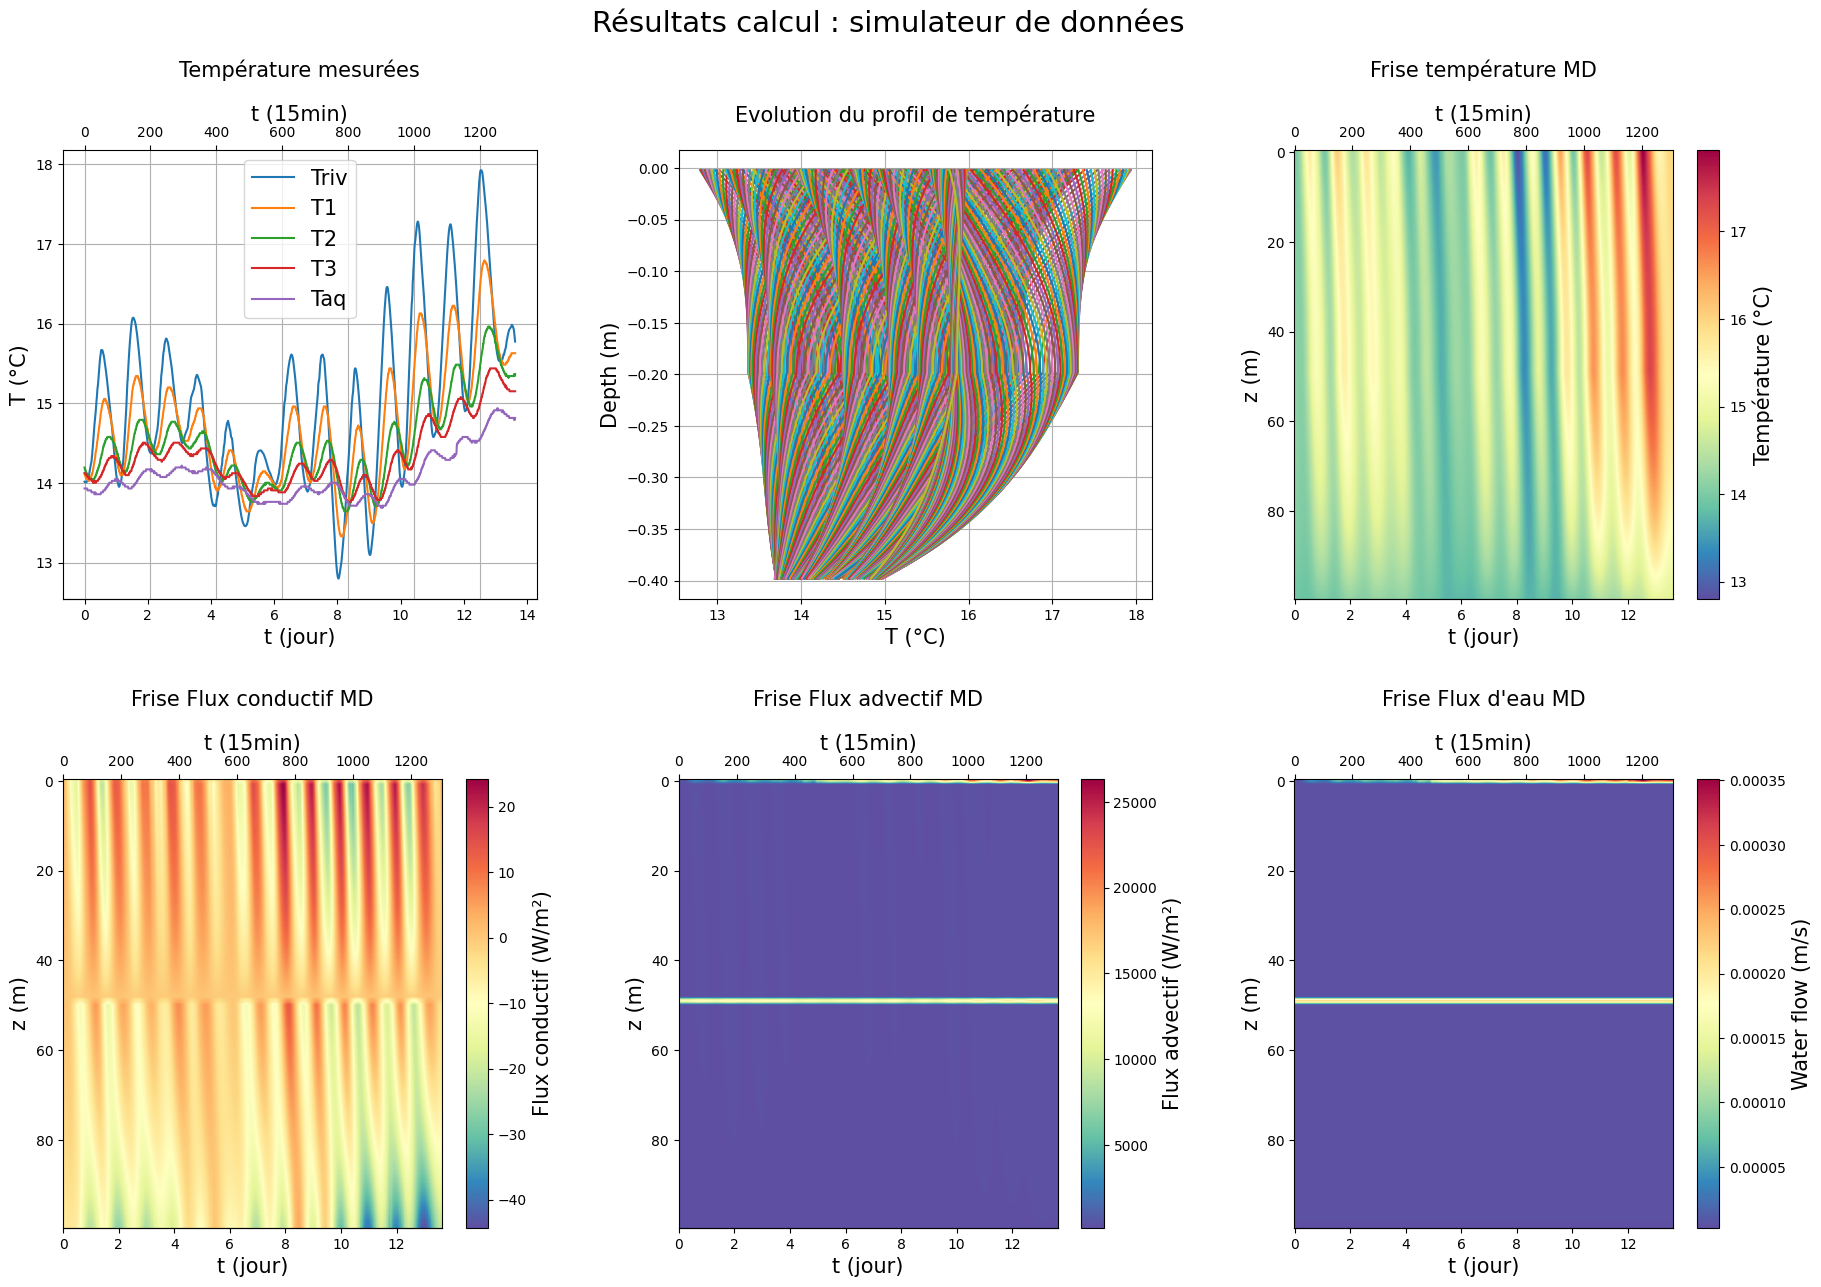

In [19]:
col.plot_CALC_results(nt=len(col._times))

On peut calculer la RMSE, et visualiser l'écart entre notre modèle **(avec des paramètres arbitraires, donc mauvais)** et les mesures.

In [20]:
rmse = col.get_RMSE()
print(f"RMSE premier capteur : {rmse[0]}")
print(f"RMSE deuxième capteur : {rmse[1]}")
print(f"RMSE troisème capteur : {rmse[2]}")
print(f"RMSE globale : {rmse[3]}")

RMSE premier capteur : 0.30095697573884556
RMSE deuxième capteur : 0.5670536207808534
RMSE troisème capteur : 0.4559336875836108
RMSE globale : 0.45460621698349646


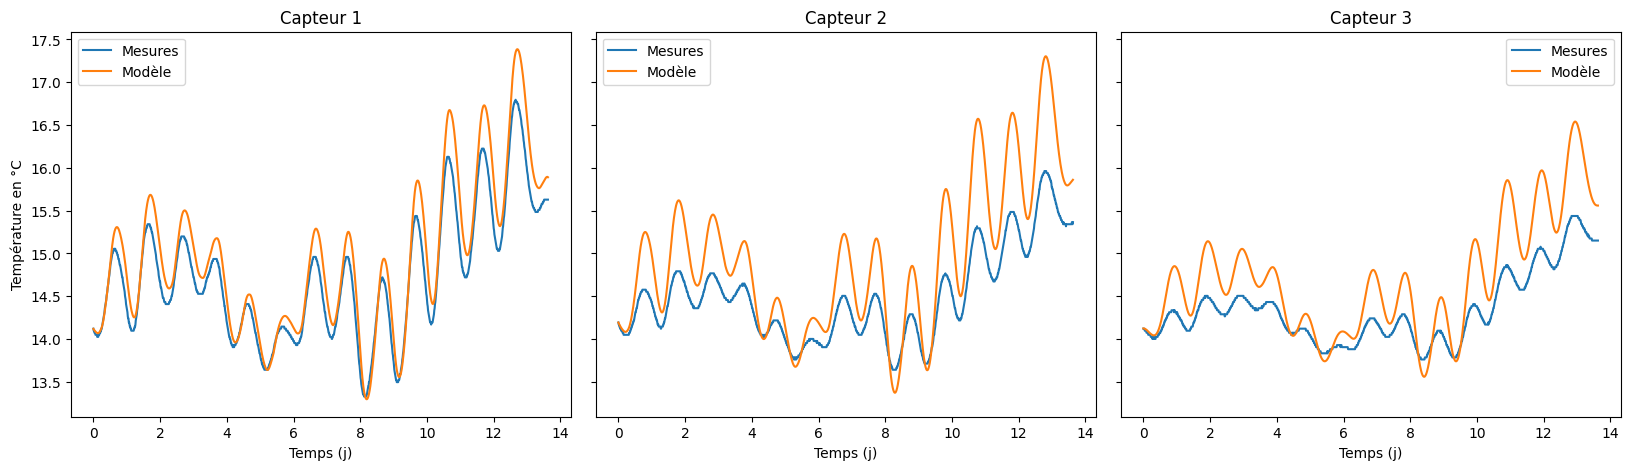

In [21]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5), sharey=True)

axes[0].set_ylabel("Température en °C")

for i, id in enumerate(col.get_id_sensors()):
    axes[i].set_xlabel("Temps (j)")
    axes[i].plot(temps_en_jours, col._T_measures[:, i] - 273.15, label="Mesures")
    axes[i].plot(temps_en_jours, col.get_temps_solve()[id] - 273.15, label="Modèle")
    axes[i].legend()
    axes[i].set_title(f"Capteur {i+1}")

plt.subplots_adjust(wspace=0.05)